# History Data-Driven Distributed Consensus in Networks

This notebook demonstrates how historical data can be used to enhance the quality of consensus decisions being made in a distributed setting. 



In [1]:
"""
Created on Sunday, Jan 03, 2021 
@author: vxr131730 - Venkatraman Renganathan 
         Control, Optimization & Networks Laboratory         
         The University of Texas at Dallas

This script is tested in Python 3.7, Windows 10, 64-bit
(C) Venkatraman Renganathan, 2020. Email: vrengana@utdallas.edu,
    Karthik Ganapathy, 2020. Email: karthik.ganapathy@utdallas.edu,
    Tyler Summers, 2020. Email: tyler.summers@utdallas.edu.

This program is a free software: you can redistribute it and/or modify it
under the terms of the GNU lesser General Public License, either version 
3.7, or any later version. This program is distributed in the hope that it 
will be useful, but WITHOUT ANY WARRANTY.
"""
###############################################################################
##################### IMPORT ALL THE REQUIRED LIBRARIES #######################
###############################################################################

# Import all the required libraries
from mosek import *
import numpy as np
import cvxpy as cp
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from numpy import linalg as LA
from pyvis.network import Network
from numpy import random as npr

## Define the communication graph and visualize it

In [2]:
###############################################################################
##################### DEFINE THE COMMUNICATION GRAPH DETAILS ##################
###############################################################################

A = np.array([[0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1, 1, 0, 1],
              [0, 0, 0, 1, 1, 0, 1, 1],
              [0, 1, 1, 0, 0, 0, 0, 1],
              [1, 1, 1, 0, 0, 1, 1, 1],
              [1, 1, 0, 0, 1, 0, 1, 1],
              [1, 0, 1, 0, 1, 1, 0, 1],
              [0, 1, 1, 1, 1, 1, 1, 0]]) # Deterministic Adjacency Matrix

N = 10   # Desired number of agents 
p = 0.5  # Probability of edge connection for erdos-renyi graph

# Generate a connected random graph with N nodes
connectivityCheck = False
while connectivityCheck is False:
    G = nx.generators.random_graphs.erdos_renyi_graph(N, p)
    if nx.is_connected(G):
        A = nx.to_numpy_matrix(G) + np.identity(N)
        connectivityCheck = True

D = np.diagflat(A.sum(axis=1)) # Degree Matrix               
L = D - A       # Laplacian matrix
N = A.shape[0]  # Number of agents

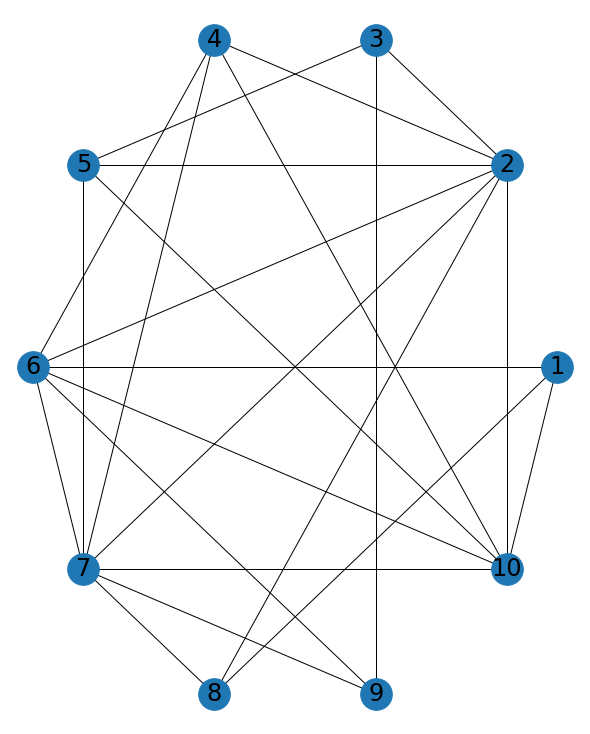

In [3]:
# Display The Communication Graph using networkx tools
G = nx.from_numpy_matrix(A)
labeldict = {}
for i in range(N):
    labeldict[i] = str(i+1)
plt.figure(figsize=(8,10))
nx.draw_circular(G, node_size=1000, labels = labeldict, with_labels = True, font_size = 24, font_color='k')

## Get neighbor information of all agents in network

In [4]:
def Get_Neighbors(i, L):
    """
    Function Get_Neighbors returns the list of in-neighbors of agent i at time k
    
    INPUTS:
    i : Index of the querying agent 
    L : Graph Laplacian Matrix
    
    OUTPUT:
    inNeighbors: Numpy array of values of neighbors
    """
    
    # Array of range of numbers from 1 to N representing agentIDs
    agentIDs = np.arange(N)+1
    
    # Extract the i^{th} column of Laplacian Matrix and stack it with neighbor values                      
    stackedCols = np.column_stack((agentIDs.reshape(-1,1), L[:,i]))    

    # Extract only in-neighbors & convert to list                           
    inNeighbors = np.ravel(stackedCols[np.where(stackedCols[:,1] < 0),0][0,:]).tolist()
    
    return inNeighbors

In [5]:
# Get neighbor information for all agents
neighborSets = []
for i in range(N):
    neighborSets.append(Get_Neighbors(i, L))
    iNeughbor = neighborSets[-1]
    print('The neighbors of agent', i+1, 'are:', neighborSets[-1])

The neighbors of agent 1 are: [6.0, 8.0, 10.0]
The neighbors of agent 2 are: [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0]
The neighbors of agent 3 are: [2.0, 5.0, 9.0]
The neighbors of agent 4 are: [2.0, 6.0, 7.0, 10.0]
The neighbors of agent 5 are: [2.0, 3.0, 7.0, 10.0]
The neighbors of agent 6 are: [1.0, 2.0, 4.0, 7.0, 9.0, 10.0]
The neighbors of agent 7 are: [2.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0]
The neighbors of agent 8 are: [1.0, 2.0, 7.0]
The neighbors of agent 9 are: [3.0, 6.0, 7.0]
The neighbors of agent 10 are: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0]


## Define history of values of all agents along with their consensus for all past time steps

In [6]:
def Get_Neighbors_Values(i, L, X_k):
    """
    Function Get_Neighbors_Values returns the information state of in-neighbors of agent i at time k
    
    INPUTS:
    i : Index of the querying agent
    L : Graph Laplacian Matrix
    X_k : Initial value of agents
    valueFlag: Flag to decide if values are to be returned along with neighbor ids
    
    OUTPUT:
    iNeighborsValues: Numpy array of values of neighbors values at time k
    """
    
    # Array of range of numbers from 1 to N representing agentIDs
    agentIDs = np.arange(N)+1
    
    # Extract the i^{th} column of Laplacian Matrix and stack it with neighbor values                      
    stackedCols = np.column_stack((agentIDs.reshape(-1,1), X_k, L[:,i]))

    # Extract only in-neighbors                            
    inNeighbors = stackedCols[np.where(stackedCols[:,2] < 0),:2][0,:]
    
    # Return the second column which has the values
    iNeighborsValues = np.ravel(inNeighbors[:,1])
    
    return iNeighborsValues
    

In [7]:
###############################################################################
##################### DEFINE THE SIMULATION PROBLEM DATA ######################
###############################################################################

HT = 5 # Length of historical values stored in rolling fashion    
XHistory = 50*npr.rand(N,HT) # Initial values of N agents for all HT times (Incremental storage or rolling storage)
meanHistory = np.mean(XHistory, axis=0) # Initial history of average for all HT times (Incremental storage or rolling storage)

Neighbor Values of agent 1 are: [15.53035319 11.33456537 18.16289465]
Neighbor Values of agent 2 are: [11.47116393 32.60817196 13.43820795 15.53035319 37.2257962  11.33456537
 18.16289465]
Neighbor Values of agent 3 are: [20.79670624 13.43820795 11.47261147]
Neighbor Values of agent 4 are: [20.79670624 15.53035319 37.2257962  18.16289465]
Neighbor Values of agent 5 are: [20.79670624 11.47116393 37.2257962  18.16289465]
Neighbor Values of agent 6 are: [29.77979604 20.79670624 32.60817196 37.2257962  11.47261147 18.16289465]
Neighbor Values of agent 7 are: [20.79670624 32.60817196 13.43820795 15.53035319 11.33456537 11.47261147
 18.16289465]
Neighbor Values of agent 8 are: [29.77979604 20.79670624 37.2257962 ]
Neighbor Values of agent 9 are: [11.47116393 15.53035319 37.2257962 ]
Neighbor Values of agent 10 are: [29.77979604 20.79670624 32.60817196 13.43820795 15.53035319 37.2257962 ]


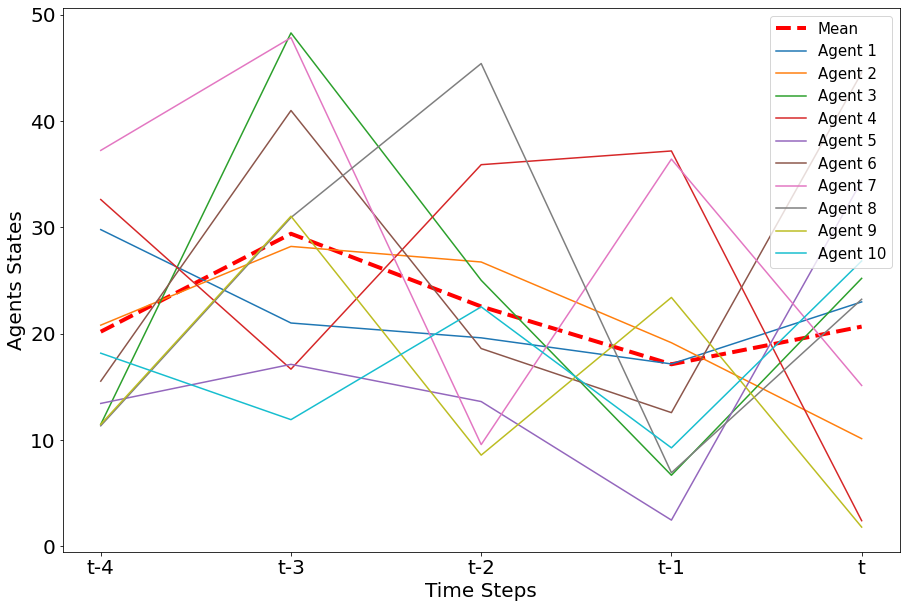

In [8]:
# CHECK CODE
for i in range(N):
    print('Neighbor Values of agent', i+1, 'are:', Get_Neighbors_Values(i, L, XHistory[:,0]))

# Plot the historical values and average
timeVector = np.arange(HT)
legText = 'Agent '
legendText = ['Mean']
labText = ['t']
xTickLabels = []
for t in range(HT-1,-1,-1):
    addText = str(-(t))
    if t == 0:
        addText = ''
    xTickLabels.append('t'+addText)
#labels = ['t-4', 't-3', 't-2', 't-1', 't']
for i in range(N):
    legendText.append(legText+str(i+1))
plt.figure(figsize=(15,10))
plt.plot(timeVector, meanHistory, '--r', linewidth = 4)
plt.plot(timeVector, XHistory.T)
plt.xlabel("Time Steps", fontsize=20)
plt.ylabel("Agents States", fontsize=20)  
plt.xticks(timeVector, xTickLabels)
plt.tick_params(axis='both', labelsize=20) 
plt.legend(legendText, fontsize=15, loc='upper right')

## Randomized Weighting Based Distributed Consensus Algorithm
Every reliable agent $i \in \mathcal{V}$ updates its states using the following randomized weighting based distributed consensus protocol 
\begin{align} 
    z_i(t) &\sim U[0,1]^{d_{i}+1}, \\
    w_{ij}(t) &= \frac{[z_{i}]_{j}}{\left\Vert z_{i} \right \|_{1}}, j \in \mathcal{J}_{i},\\
    x_{i}(t+1) &= \sum_{j \in \mathcal{J}_{i}} w_{ij}(t) x_{j}(t).
\label{eqn_d3r_wt}
\end{align}

In [9]:
def Randomized_Consensus_Protocol(xNow, iNeighborsValues):
    """
    Function Randomized_Consensus_Protocol updates the state of each agents
    after computing the weights of all in-neighbors in a randomized manner.
    
    INPUTS:
    xNow: Value of agent i's value at time t
    iNeighborsValues: Values of agent i's neighbors values at time t
    
    OUTPUT:
    xNext: Next state
    """   
    
    # Get the dimension : Add  1 to include self loop
    d_i = len(iNeighborsValues) + 1
           
    # Calculate random weights
    randomWeights = np.random.rand(d_i)    
    
    # Normalize the weights
    weights = randomWeights/(LA.norm(randomWeights, 1))
    
    # Append the ith agent values with neighbors to form inclusive neighbor values
    xvalues = np.append(xNow, iNeighborsValues)
    
    # Compute the weighted average
    xNext = np.average(xvalues, weights=weights)
    
    return xNext

## Main Simulation Start

In [28]:
# Define parameters to simulate the system for T time steps forward
T = 50 # Future Time Span   
faultyIndices = [2, 5] # Indices of faulty agents

# Place holders for storing the states and means
x = np.zeros((N,T+1)) # Placeholder to store all states values in future
xMeans = np.zeros(T+1) # Placeholder to store all mean values in future

# Populate the first entries using last known values
x[:,0] = XHistory[:,0] # Last Recent history
xMeans[0] = np.mean(x[:,0]) # computed mean form current state

for t in range(T):
    for i in range(N):
        
        # If Agents i is faulty, update its value randomly
        if i in faultyIndices:
            cho = np.random.randint(2)
            if cho == 0:
                x[i,t+1] = x[i,t] + np.random.rand() 
            else:
                x[i,t+1] = x[i,t] - np.random.rand() 
            continue
        
        # Get the neighbors of agent i
        iNeighbors = neighborSets[i]
        
        # Get the neighbors' state value
        iNeighborsValues = Get_Neighbors_Values(i, L, x[:,t])
        
        # Update using the Randomized_Consensus_Protocol
        x[i,t+1] = Randomized_Consensus_Protocol(x[i,t], iNeighborsValues) 
    
    # Once all agents update their values based on their respective neighbor trusts, update the overall average
    xMeans[t+1] = np.mean(x[:,t+1])

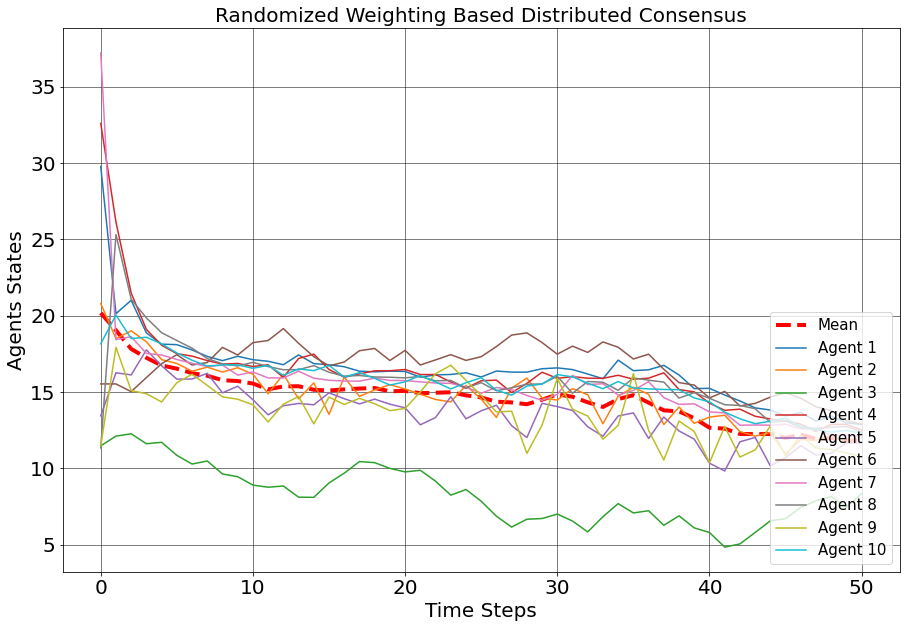

In [29]:
# Plot the historical values and average
timeVector = np.arange(T+1)
legText = 'Agent '
legendText = ['Mean']
malText = '(Malicious)'
for i in range(N):
    
    legendText.append(legText+str(i+1))
plt.figure(figsize=(15,10))
plt.plot(timeVector, xMeans, '--r', linewidth = 4)
plt.plot(timeVector, x.T)
plt.xlabel("Time Steps", fontsize=20)
plt.ylabel("Agents States", fontsize=20)    
plt.tick_params(axis='both', labelsize=20)
plt.title("Randomized Weighting Based Distributed Consensus", fontsize=20)
plt.legend(legendText, fontsize=15, loc='lower right')
plt.grid(color='k', linestyle='-', linewidth=0.5)

## Use the historical data to solve this problem